# EDA

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Train data

In [2]:
train_df = pd.read_csv('data/train.csv')
train_df.head()

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
0,1_20220601 00,1,20220601 00,18.6,NaN,0.9,42.0,NaN,NaN,1085.28
1,1_20220601 01,1,20220601 01,18.0,NaN,1.1,45.0,NaN,NaN,1047.36
2,1_20220601 02,1,20220601 02,17.7,NaN,1.5,45.0,NaN,NaN,974.88
3,1_20220601 03,1,20220601 03,16.7,NaN,1.4,48.0,NaN,NaN,953.76
4,1_20220601 04,1,20220601 04,18.4,NaN,2.8,43.0,NaN,NaN,986.40


In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204000 entries, 0 to 203999
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   num_date_time  204000 non-null  object 
 1   건물번호           204000 non-null  int64  
 2   일시             204000 non-null  object 
 3   기온(C)          204000 non-null  float64
 4   강수량(mm)        43931 non-null   float64
 5   풍속(m/s)        203981 non-null  float64
 6   습도(%)          203991 non-null  float64
 7   일조(hr)         128818 non-null  float64
 8   일사(MJ/m2)      116087 non-null  float64
 9   전력소비량(kWh)     204000 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 15.6+ MB


총 204000개의 데이터.  
1. 일시 컬럼은 년, 월, 일, 시간으로 구성(object타입) -> 월, 일, 시간 컬럼 생성 필요.  
2. 강수량, 풍속, 습도, 일조, 일사 컬럼들은 결측값 존재 -> 결측치 대체 필요.  
3. 건물번호대로 시계열 데이터가 존재하므로 건물번호로 나눈 데이터 분석 필요.  

### 1. 월, 일, 시간 컬럼 생성

In [4]:
train_df['month'] = train_df['일시'].apply(lambda x: int(x[4:6]))
train_df['day'] = train_df['일시'].apply(lambda x: int(x[6:8]))
train_df['time'] = train_df['일시'].apply(lambda x: int(x[9:]))
train_df.head()

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh),month,day,time
0,1_20220601 00,1,20220601 00,18.6,NaN,0.9,42.0,NaN,NaN,1085.28,6,1,0
1,1_20220601 01,1,20220601 01,18.0,NaN,1.1,45.0,NaN,NaN,1047.36,6,1,1
2,1_20220601 02,1,20220601 02,17.7,NaN,1.5,45.0,NaN,NaN,974.88,6,1,2
3,1_20220601 03,1,20220601 03,16.7,NaN,1.4,48.0,NaN,NaN,953.76,6,1,3
4,1_20220601 04,1,20220601 04,18.4,NaN,2.8,43.0,NaN,NaN,986.40,6,1,4


### 2. 결측치 대체  
건물마다, 월 마다 강수량, 풍속 등이 다를 것으로 예상.  
따라서 건물번호, 월 마다의 강수량, 풍속 등의 평균값을 구해 결측치를 대체 진행.

In [5]:
# 컬럼명 영어로 변경
train_df.rename(columns={'기온(C)':'temp', '강수량(mm)':'rain', '풍속(m/s)':'wind', '습도(%)':'humidity', '일조(hr)':'sunshine', '일사(MJ/m2)':'radiation', '전력소비량(kWh)':'power'}, inplace=True)

In [6]:
print("건물 번호 갯수: ",len(train_df['건물번호'].unique()))

건물 번호 갯수:  100


In [7]:
# 결측값 대체 함수
def fill_na(df):
    for n in df['건물번호'].unique():
        df_values = df[df['건물번호']==n].groupby('month').agg({
            'rain':'mean',
            'wind':'mean',
            'humidity':'mean',
            'sunshine':'mean',
            'radiation':'mean'
            }).reset_index().values
        
        for df_value in df_values:
            df['rain'] = (lambda x,y: df_value[1])(df['건물번호']==n, df['month']==int(df_value[0]))
            df['wind'] = (lambda x,y: df_value[2])(df['건물번호']==n, df['month']==int(df_value[0]))
            df['humidity'] = (lambda x,y: df_value[3])(df['건물번호']==n, df['month']==int(df_value[0]))
            df['sunshine'] = (lambda x,y: df_value[4])(df['건물번호']==n, df['month']==int(df_value[0]))
            df['radiation'] = (lambda x,y: df_value[5])(df['건물번호']==n, df['month']==int(df_value[0]))            

    return df

In [8]:
train_df2 = fill_na(train_df)
train_df2.isna().sum()

num_date_time    0
건물번호             0
일시               0
temp             0
rain             0
wind             0
humidity         0
sunshine         0
radiation        0
power            0
month            0
day              0
time             0
dtype: int64

### 3. 건물 번호 나누어 전력사용량 분석

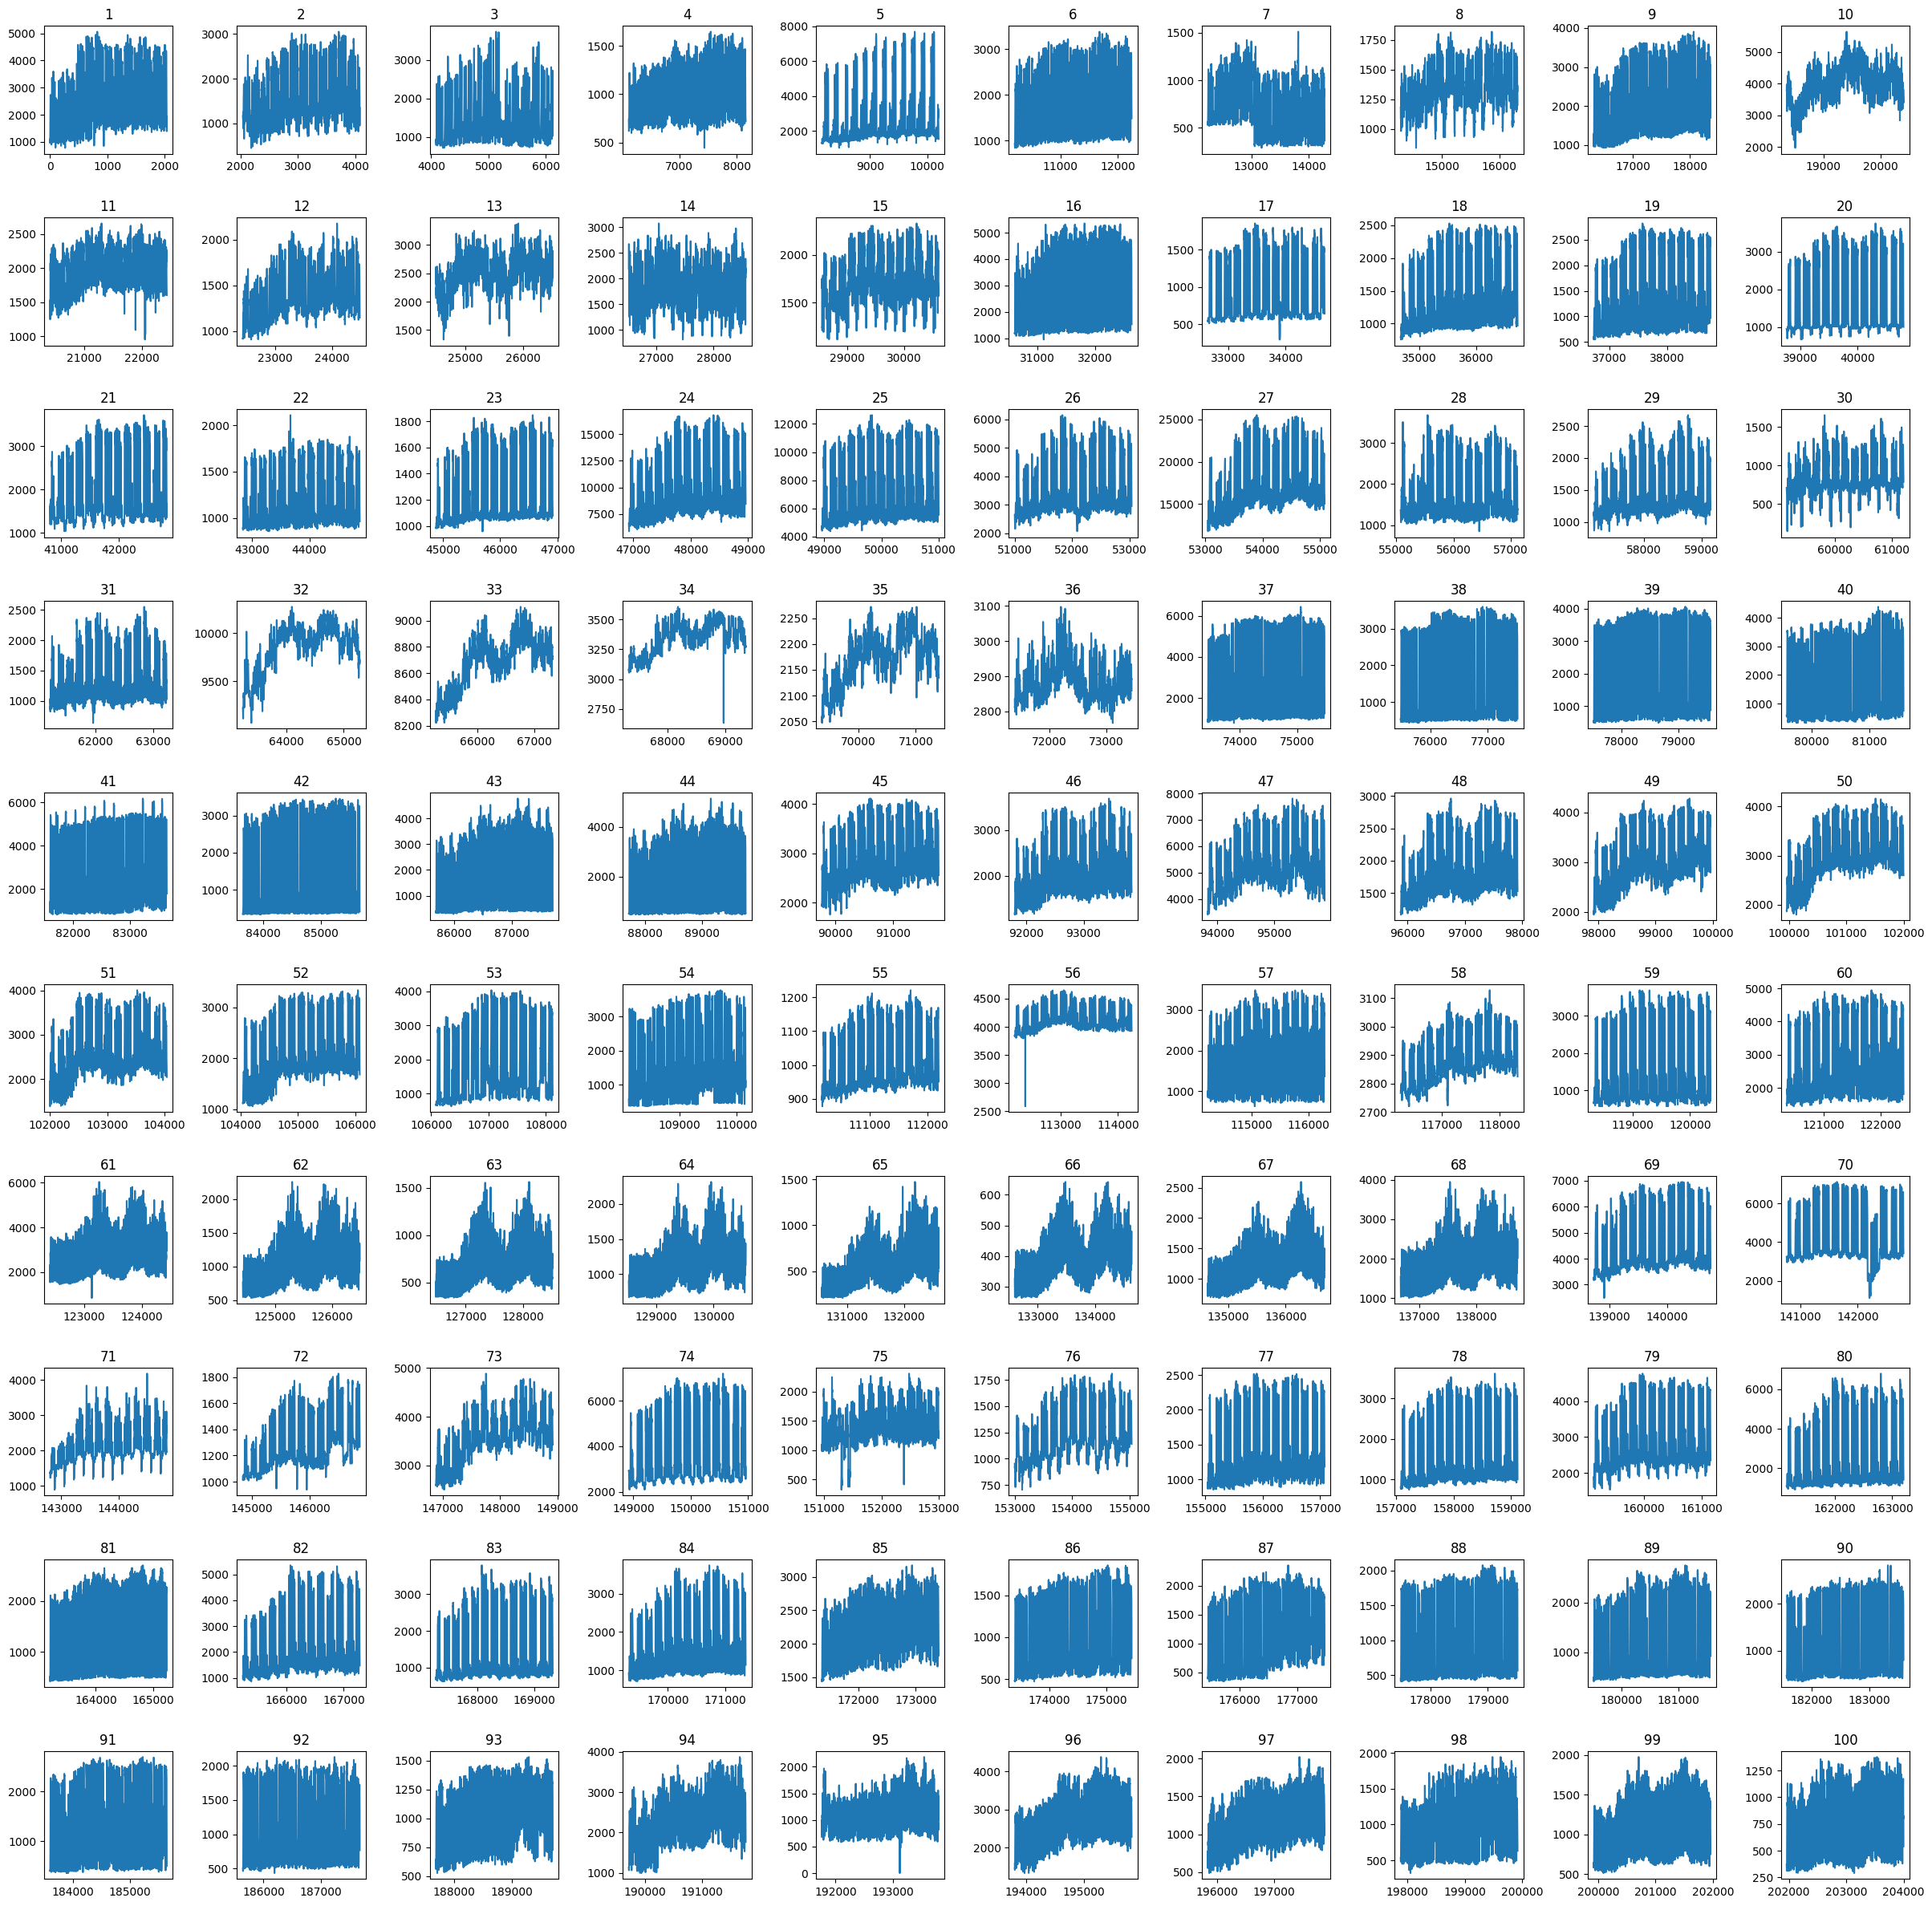

In [14]:
f, axes = plt.subplots(10, 10)
f.set_size_inches((30,30))
plt.subplots_adjust(wspace=0.5, hspace=0.5)

cnt = 0
for i, n in enumerate(train_df2['건물번호'].unique()):
    if i == 0 or (i%10!=0): 
        axes[cnt, int(i%10)].set_title(f'{n}')
        axes[cnt, int(i%10)].plot(train_df2[train_df2['건물번호']==n]['power'])
    else:
        cnt += 1
        axes[cnt, int(i%10)].set_title(f'{n}')
        axes[cnt, int(i%10)].plot(train_df2[train_df2['건물번호']==n]['power'])
plt.show()

뚜렷한 추세를 보이는 그래프도 보이지만 딱히 추세가 나타나지 않는 그래프도 존재.